In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import zipfile
import os

from collections import Counter

from torchvision import datasets,transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch
import torchsummary


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_data = zipfile.ZipFile('/content/drive/MyDrive/Plant_leave_diseases_dataset.zip','r')
zip_data.extractall('/tmp')
zip_data.close()

In [ ]:
dataset_dir = '/tmp/Plant_leave_diseases_dataset'
print(len(os.listdir(dataset_dir)))

39


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)


subset_size = int(0.2* len(dataset))
subset_dataset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])


train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])


batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

 **DATA EXPLORATION**


Number of Images: 55448
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spo

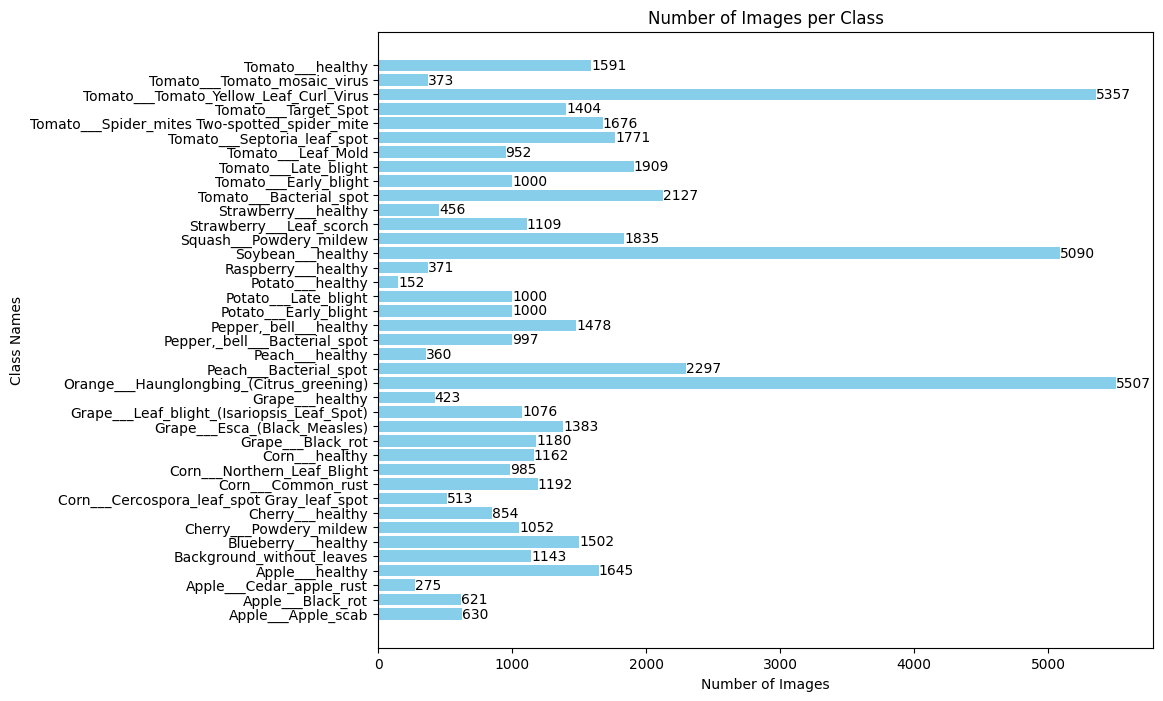

In [ ]:
class_names = dataset.classes
print("Number of Images: {}".format(len(dataset)))
print("Class names: {}".format(class_names))
print("Total number of classes: {}\n".format(len(class_names)))

plants = []
number_diseases = 0

for plant in class_names:
    parts = plant.split('___')

    # Skip if format does not match 'plant___disease'
    if len(parts) != 2:
        print(f"Skipping \"{plant}\" class ")
        continue

    plant_name, disease_status = parts[0], parts[1]

    if plant_name not in plants:
        plants.append(plant_name)
    if disease_status != 'healthy':
        number_diseases += 1

print(f"Unique Plants are: {plants}\n")
print("Number of plants: {}".format(len(plants)))
print("Number of diseases: {}\n".format(number_diseases))



class_counts = Counter(dataset.targets)

classes = [class_names[class_idx] for class_idx in class_counts.keys()]
counts = list(class_counts.values())

# Plot the data
plt.figure(figsize=(10,8))
bars =plt.barh(classes, counts, color='skyblue')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             str(bar.get_width()), va='center', ha='left', fontsize=10)

plt.xlabel('Number of Images')
plt.ylabel('Class Names')
plt.title('Number of Images per Class')
plt.show()
print("\n\n")
#classes are severely imbalanced - use f1 score as performance metric


healthy_classes = defaultdict(int)
diseased_classes = defaultdict(int)
for plant in class_names:
    parts = plant.split('___')

    if len(parts) != 2:
        print(f"Skipping \"{plant}\" class ")
        continue

    plant_name, disease_status = parts[0], parts[1]
    if disease_status == 'healthy':
        healthy_classes[plant_name] += 1
    else:
        diseased_classes[plant_name] += 1

table_data = []


for plant in healthy_classes:
    table_data.append([plant, healthy_classes[plant], diseased_classes[plant]])


headers = ['Plant', 'Number of Healthy Classes', 'Number of Diseased Classes']
print(tabulate(table_data, headers=headers, tablefmt="grid"))



In [ ]:
print(train_dataset[0]) #each datapoint is of the form img_data,target_label in a tuple





Skipping "Background_without_leaves" class 
+--------------+-----------------------------+------------------------------+
| Plant        |   Number of Healthy Classes |   Number of Diseased Classes |
+==============+=============================+==============================+
| Apple        |                           1 |                            3 |
+--------------+-----------------------------+------------------------------+
| Blueberry    |                           1 |                            0 |
+--------------+-----------------------------+------------------------------+
| Cherry       |                           1 |                            1 |
+--------------+-----------------------------+------------------------------+
| Corn         |                           1 |                            3 |
+--------------+-----------------------------+------------------------------+
| Grape        |                           1 |                            3 |
+--------------+-

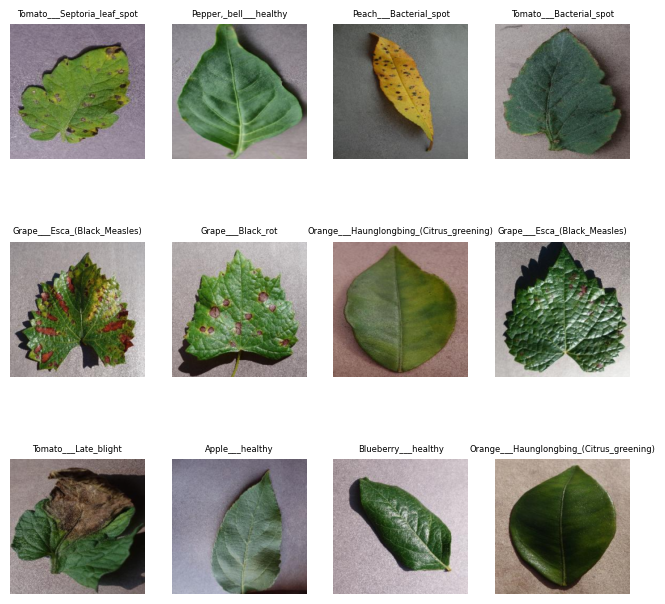

In [ ]:
plt.figure(figsize=(8,8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    image=train_dataset[i][0].permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
    plt.imshow(image)
    label = class_names[train_dataset[i][1]]
    plt.title(label,fontsize=6)
    plt.axis('off')

plt.show()

In [ ]:
print('Size of the Dataset: ',len(dataset))
print('Size of the training dataset: ',len(train_dataset))
print('Size of the testing dataset: ',len(test_dataset))

Size of the Dataset:  55448
Size of the training dataset:  8871
Size of the testing dataset:  2218


**FEATURE EXTRACTION WITH CNN**


In [ ]:
def extract_features(model, loader, device='cuda'):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            outputs = outputs.reshape(outputs.shape[0], -1) # Flatten to [batch_size, num_features]
            features.append(outputs)
            labels.append(targets.numpy())

    # Concatenate features and labels to create final X and y
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)


    return features, labels

In [ ]:
#alexnet
# Load pre-trained AlexNet model
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
alexnet = torch.nn.Sequential(*list(alexnet.children())[:-2])
alexnet = alexnet.to(device)
torchsummary.summary(alexnet, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 147MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
Total params: 2,469,696
Trainable param

In [ ]:
#extracting feature maps of train and test dataset
train_features, train_labels = extract_features(alexnet,train_loader, device=device)
test_features, test_labels = extract_features(alexnet,test_loader, device=device)

#scaling
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

print("Length of train features:", len(train_features))
print("Length of test features:", len(test_features))




Length of train features: 8871
Length of test features: 2218


**TRAINING MODELS**

In [ ]:
# Dictionary to hold f1 results
cv_f1_results = {}



models = {
    "Logistic Regression": LogisticRegression(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "Random Forest": RandomForestClassifier(random_state=123),
    "SVM": SVC(random_state=123),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes":GaussianNB()
}

In [ ]:
f1_threshold = 0.75
test_f1_results = {}
cv_f1_results = {}
selected_models = []


for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with 3-fold cross-validation...")

    # Perform 3-fold cross-validation on the entire dataset
    cv_scores = cross_val_score(model, train_features, train_labels, cv=3, scoring='f1_weighted')
    mean_cv_score = np.mean(cv_scores)
    cv_f1_results[model_name] = mean_cv_score

    print(f"{model_name} - Mean CV F1 Score (3-fold): {mean_cv_score:.2f}")

    if mean_cv_score >= f1_threshold:
        selected_models.append(model_name)





Evaluating Logistic Regression with 3-fold cross-validation...
Logistic Regression - Mean CV F1 Score (3-fold): 0.94

Evaluating Decision Tree with 3-fold cross-validation...
Decision Tree - Mean CV F1 Score (3-fold): 0.44

Evaluating Random Forest with 3-fold cross-validation...
Random Forest - Mean CV F1 Score (3-fold): 0.74

Evaluating SVM with 3-fold cross-validation...
SVM - Mean CV F1 Score (3-fold): 0.89

Evaluating KNN with 3-fold cross-validation...
KNN - Mean CV F1 Score (3-fold): 0.64

Evaluating Naive Bayes with 3-fold cross-validation...
Naive Bayes - Mean CV F1 Score (3-fold): 0.48


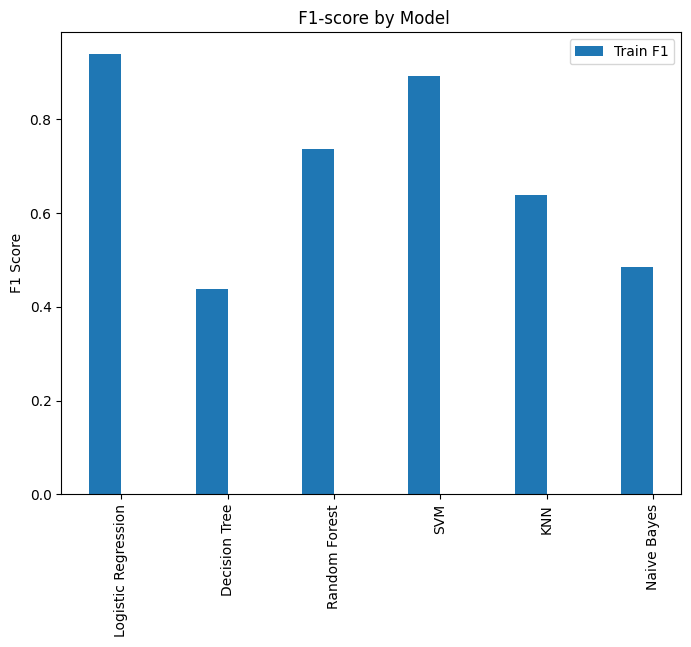

In [ ]:
labels = list(cv_f1_results.keys())
f1 = [value for value in cv_f1_results.values()]

x = np.arange(len(labels))
width = 0.3
plt.figure(figsize=(8,6))
plt.bar(x - width/2, f1, width, label='Train F1')
plt.ylabel('F1 Score')
plt.title(' F1-score by Model')
plt.xticks(ticks=x, labels=labels, fontsize=10, rotation=90)
plt.legend()
plt.show()


EVALUATION ON TEST DATA


In [ ]:
best_model_name = None
best_model_f1 = 0
best_model=None

for model_name in selected_models:
    model = models[model_name]
    model.fit(train_features, train_labels)

    test_predictions = model.predict(test_features)
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')

    test_f1_results[model_name] = test_f1
    print(f"{model_name} - Test F1 Score: {test_f1:.2f}")


    if test_f1>best_model_f1:
      best_model=model
      best_model_name=model_name











Logistic Regression - Test F1 Score: 0.96
SVM - Test F1 Score: 0.92


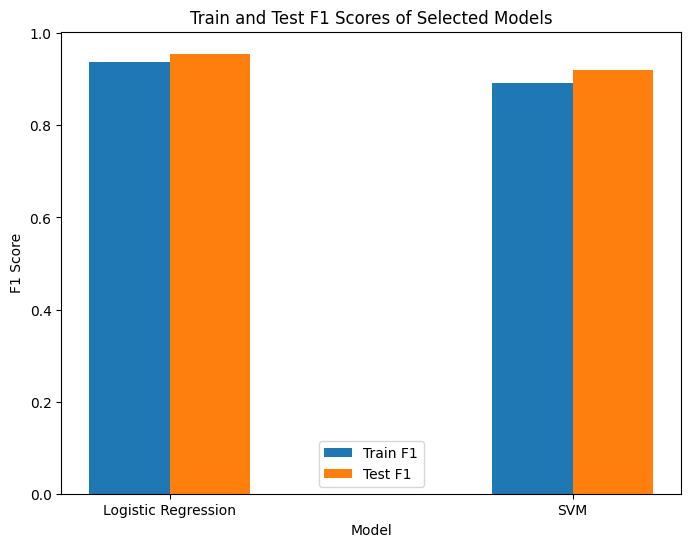

In [ ]:
cv_scores_selected = [cv_f1_results[model_name] for model_name in selected_models]
test_scores_selected = [test_f1_results[model_name] for model_name in selected_models]


plt.figure(figsize=(8, 6))
x = np.arange(len(selected_models))
bar_width = 0.2

plt.bar(x - bar_width/2, cv_scores_selected, bar_width, label='Train F1')
plt.bar(x + bar_width/2, test_scores_selected, bar_width, label='Test F1')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Train and Test F1 Scores of Selected Models')
plt.xticks(x, selected_models)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
test_predictions = best_model.predict(test_features)
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.97      1.00      0.98        28
           2       0.91      0.67      0.77        15
           3       0.96      0.96      0.96        73
           4       1.00      0.96      0.98        56
           5       1.00      1.00      1.00        57
           6       0.97      1.00      0.98        31
           7       0.95      0.98      0.96        41
           8       0.94      0.83      0.88        18
           9       1.00      1.00      1.00        40
          10       0.90      0.93      0.91        40
          11       0.98      1.00      0.99        40
          12       1.00      0.98      0.99        62
          13       0.99      1.00      0.99        66
          14       1.00      0.97      0.99        40
          15       1.00      1.00      1.00        19
          16       1.00      0.98      0.99       213
          17       0.98    

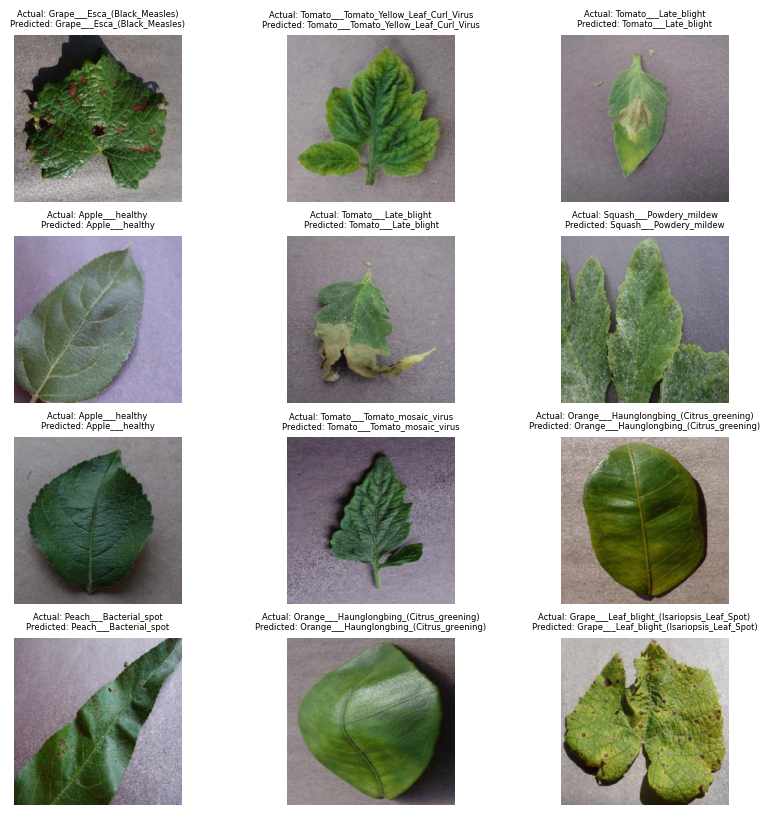

In [ ]:
num_samples = 12
sample_images = test_features[:num_samples]
sample_labels = test_labels[:num_samples]


sample_preds = best_model.predict(sample_images)

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3, i+1)
    image=test_dataset[i][0].permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
    plt.imshow(image)
    actual_label = class_names[test_dataset[i][1]]
    plt.title(f"Actual: {actual_label}\nPredicted: {class_names[sample_preds[i]]}",fontsize=6)
    plt.axis('off')

plt.show()